In [ ]:
import sys
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import os
import matplotlib.pyplot as plt
import numpy as np
import ot
import time
import numba

parent_path='/home/baly/projects/Sliced_opt/code'
sys.path.append(parent_path)
os.chdir(parent_path)
from sopt.library import *
from sopt.lib_shape import *
from sopt.lib_ot import *   
from sopt.sliced_opt import *  


In [2]:
@nb.njit((nb.float64[:,:])(nb.float64[:],nb.float64[:],nb.float64[:,:],nb.float64,nb.float64,nb.int64))
def sinkhorn_opt_pr(mu, nu, M, mass, reg, numItermax=100000):
    r"""
    Solves the partial optimal transport problem
    and returns the OT plan

    The function considers the following problem:

    .. math::
        \gamma = \mathop{\arg \min}_\gamma \quad \langle \gamma,
                 \mathbf{M} \rangle_F + \mathrm{reg} \cdot\Omega(\gamma)

        s.t. \gamma \mathbf{1} &\leq \mathbf{a} \\
             \gamma^T \mathbf{1} &\leq \mathbf{b} \\
             \gamma &\geq 0 \\
             \mathbf{1}^T \gamma^T \mathbf{1} = m
             &\leq \min\{\|\mathbf{a}\|_1, \|\mathbf{b}\|_1\} \\

    where :

    - :math:`\mathbf{M}` is the metric cost matrix
    - :math:`\Omega`  is the entropic regularization term,
      :math:`\Omega=\sum_{i,j} \gamma_{i,j}\log(\gamma_{i,j})`
    - :math:`\mathbf{a}` and :math:`\mathbf{b}` are the sample weights
    - `m` is the amount of mass to be transported

    The formulation of the problem has been proposed in
    :ref:`[3] <references-entropic-partial-wasserstein>` (prop. 5)


    Parameters
    ----------
    mu : np.ndarray (dim_a,)
        Unnormalized histogram of dimension `dim_a`
    b : np.ndarray (dim_b,)
        Unnormalized histograms of dimension `dim_b`
    M : np.ndarray (dim_a, dim_b)
        cost matrix
    reg : float
        Regularization term > 0
    m : float, optional
        Amount of mass to be transported
    numItermax : int, optional
        Max number of iterations
    stopThr : float, optional
        Stop threshold on error (>0)
    verbose : bool, optional
        Print information along iterations
    log : bool, optional
        record log if True


    Returns
    -------
    gamma : (dim_a, dim_b) ndarray
        Optimal transportation matrix for the given parameters
    log : dict
        log dictionary returned only if `log` is `True`


    Examples
    --------
    >>> import ot
    >>> mu = [.1, .2]
    >>> nu = [.1, .1]
    >>> M = [[0., 1.], [2., 3.]]
    >>> np.round(entropic_partial_wasserstein(a, b, M, 1, 0.1), 2)
    array([[0.06, 0.02],
           [0.01, 0.  ]])


    .. _references-entropic-partial-wasserstein:
    References
    ----------
    .. [3] Benamou, J. D., Carlier, G., Cuturi, M., Nenna, L., & Peyré, G.
       (2015). Iterative Bregman projections for regularized transportation
       problems. SIAM Journal on Scientific Computing, 37(2), A1111-A1138.

    See Also
    --------
    ot.partial.partial_wasserstein: exact Partial Wasserstein
    """

    #mu = np.asarray(a, dtype=np.float64)
    #nu = np.asarray(b, dtype=np.float64)
    #M = np.asarray(M, dtype=np.float64)

    dim_mu, dim_nu = M.shape
    dx = np.ones(dim_mu, dtype=np.float64)
    dy = np.ones(dim_nu, dtype=np.float64)
    stopThr=1e-13
            

    # Next 3 lines equivalent to K=np.exp(-M/reg), but faster to compute
    K=np.exp(-M/reg)
    #K = np.empty(M.shape, dtype=M.dtype)
    #np.divide(M, -reg, out=K)
    #np.exp(K, out=K)
    
    K=K*mass / np.sum(K) # make the total mass of K to be mass
    
    err, cpt = 1, 0
    q1 = np.ones(K.shape)
    q2 = np.ones(K.shape)
    q3 = np.ones(K.shape)

    while (err > stopThr and cpt < numItermax):
        Kprev = K
        K = K * q1
        K1 = np.dot(np.diag(np.minimum(mu / np.sum(K, axis=1), dx)), K)
        q1 = q1 * Kprev / K1
        K1prev = K1
        K1 = K1 * q2
        K2 = np.dot(K1, np.diag(np.minimum(nu / np.sum(K1, axis=0), dy)))
        q2 = q2 * K1prev / K2
        K2prev = K2
        K2 = K2 * q3
        K = K2 * (mass / np.sum(K2))
        q3 = q3 * K2prev / K


        if cpt % 10 == 0:
            err = np.linalg.norm(Kprev - K)

        cpt = cpt + 1
    if cpt==numItermax-1:
        print('warning, maximum iteration reached')
    # log_e['partial_w_dist'] = np.sum(M * K)
    # if log:
    #     return K, log_e
    return K

In [3]:
@nb.njit((nb.float64[:,:])(nb.float64[:],nb.float64[:],nb.float64[:,:],nb.float64,nb.int64))
def sinkhorn_knopp(mu, nu, M, reg, numItermax=1000000):
    r"""
    Solve the entropic regularization optimal transport problem and return the OT matrix

    The function solves the following optimization problem:

    .. math::
        \gamma = \mathop{\arg \min}_\gamma \quad \langle \gamma, \mathbf{M} \rangle_F +
        \mathrm{reg}\cdot\Omega(\gamma)

        s.t. \ \gamma \mathbf{1} &= \mathbf{a}

             \gamma^T \mathbf{1} &= \mathbf{b}

             \gamma &\geq 0
    where :

    - :math:`\mathbf{M}` is the (`dim_a`, `dim_b`) metric cost matrix
    - :math:`\Omega` is the entropic regularization term
      :math:`\Omega(\gamma)=\sum_{i,j} \gamma_{i,j}\log(\gamma_{i,j})`
    - :math:`\mathbf{a}` and :math:`\mathbf{b}` are source and target
      weights (histograms, both sum to 1)

    The algorithm used for solving the problem is the Sinkhorn-Knopp
    matrix scaling algorithm as proposed in :ref:`[2] <references-sinkhorn-knopp>`


    Parameters
    ----------
    mu : array-like, shape (mu,)
        samples weights in the source domain
    nu : array-like, shape (nu,) or array-like, shape (dim_b, n_hists)
        samples in the target domain, compute sinkhorn with multiple targets
        and fixed :math:`\mathbf{M}` if :math:`\mathbf{b}` is a matrix
        (return OT loss + dual variables in log)
    M : array-like, shape (dim_a, dim_b)
        loss matrix
    reg : float
        Regularization term >0
    numItermax : int, optional
        Max number of iterations
    stopThr : float, optional
        Stop threshold on error (>0)

    Returns
    -------
    gamma : array-like, shape (dim_mu, dim_nu)
        Optimal transportation matrix for the given parameters

    Examples
    --------

    >>> import ot
    >>> mu=[.5, .5]
    >>> nu=[.5, .5]
    >>> M=[[0., 1.], [1., 0.]]
    >>> ot.sinkhorn(a, b, M, 1)
    array([[0.36552929, 0.13447071],
           [0.13447071, 0.36552929]])


    .. _references-sinkhorn-knopp:
    References
    ----------

    .. [2] M. Cuturi, Sinkhorn Distances : Lightspeed Computation
        of Optimal Transport, Advances in Neural Information
        Processing Systems (NIPS) 26, 2013


    See Also
    --------
    ot.lp.emd : Unregularized OT
    ot.optim.cg : General regularized OT

    """

    # init data
    dim_mu = mu.shape[0]
    dim_nu = nu.shape[0]
    stopThr=1e-9
    
    #initialize u,v 
    u = np.ones(dim_mu) # is exp()
    v = np.ones(dim_nu)

    K = np.exp(-M/reg)
    
    for ii in range(numItermax):
        u_pre=u.copy()
        v_pre=v.copy()
        v = nu / np.dot(K, u)
        u = mu / np.dot(K.T, v)
        if ii % 10 == 0:
            # we can speed up the process by checking for the error only all
            # the 10th iterations
            err = np.linalg.norm(u_pre - u)+np.linalg.norm(v_pre - v)  # violation of marginal
            if err < stopThr:
                break
    
    gamma=np.expand_dims(u,1)*(K*v.T)

    return gamma


In [4]:
@nb.njit(['(float64[:,:])(float64[:],float64[:],float64[:,:],float64,float64,int64)'])
def sinkhorn_knopp_opt(mu, nu, M, Lambda, reg, numItermax=1000):
    r"""
    Solve the entropic regularization optimal transport problem and return the OT matrix

    The function solves the following optimization problem:

    .. math::
        \gamma = \mathop{\arg \min}_\gamma \quad \langle \gamma, \mathbf{M} \rangle_F +
        \mathrm{reg}\cdot\Omega(\gamma)

        s.t. \ \gamma \mathbf{1} &= \mathbf{a}

             \gamma^T \mathbf{1} &= \mathbf{b}

             \gamma &\geq 0
    where :

    - :math:`\mathbf{M}` is the (`dim_a`, `dim_b`) metric cost matrix
    - :math:`\Omega` is the entropic regularization term
      :math:`\Omega(\gamma)=\sum_{i,j} \gamma_{i,j}\log(\gamma_{i,j})`
    - :math:`\mathbf{a}` and :math:`\mathbf{b}` are source and target
      weights (histograms, both sum to 1)

    The algorithm used for solving the problem is the Sinkhorn-Knopp
    matrix scaling algorithm as proposed in :ref:`[2] <references-sinkhorn-knopp>`


    Parameters
    ----------
    mu : array-like, shape (mu,)
        samples weights in the source domain
    nu : array-like, shape (nu,) or array-like, shape (dim_b, n_hists)
        samples in the target domain, compute sinkhorn with multiple targets
        and fixed :math:`\mathbf{M}` if :math:`\mathbf{b}` is a matrix
        (return OT loss + dual variables in log)
    M : array-like, shape (dim_a, dim_b)
        loss matrix
    reg : float
        Regularization term >0
    numItermax : int, optional
        Max number of iterations
    stopThr : float, optional
        Stop threshold on error (>0)

    Returns
    -------
    gamma : array-like, shape (dim_mu, dim_nu)
        Optimal transportation matrix for the given parameters

    Examples
    --------

    >>> import ot
    >>> mu=[.5, .5]
    >>> nu=[.5, .5]
    >>> M=[[0., 1.], [1., 0.]]
    >>> ot.sinkhorn(a, b, M, 1)
    array([[0.36552929, 0.13447071],
           [0.13447071, 0.36552929]])


    .. _references-sinkhorn-knopp:
    References
    ----------

    .. [2] M. Cuturi, Sinkhorn Distances : Lightspeed Computation
        of Optimal Transport, Advances in Neural Information
        Processing Systems (NIPS) 26, 2013


    See Also
    --------
    ot.lp.emd : Unregularized OT
    ot.optim.cg : General regularized OT

    """

    # init data
    dim_mu = mu.shape[0]
    dim_nu = nu.shape[0]
    stopThr=1e-9
    
    #initialize u,v 
    u = np.ones(dim_mu) # is exp()
    v = np.zeros(dim_nu)

    K = np.exp(-M/reg)
    
    for ii in range(numItermax):
        u_pre=u.copy()
        v_pre=v.copy()
        v = np.minimum(nu / np.dot(K.T, u),Lambda)
        u = np.minimum(mu / np.dot(K, v),Lambda)
        if ii % 10 == 0:
            # we can speed up the process by checking for the error only all
            # the 10th iterations
            err = np.linalg.norm(u_pre - u)+np.linalg.norm(v_pre - v)  # violation of marginal
            if err < stopThr:
                break
    gamma=np.expand_dims(u,1)*(K*v.T)

    return gamma
    

In [5]:
@nb.njit(['(float32[:,:])(float32[:],float32[:],float32[:,:],float32,float32,int64)'])
def sinkhorn_knopp_opt_32(mu, nu, M, Lambda, reg, numItermax=1000000):
    r"""
    Solve the entropic regularization optimal transport problem and return the OT matrix

    The function solves the following optimization problem:

    .. math::
        \gamma = \mathop{\arg \min}_\gamma \quad \langle \gamma, \mathbf{M} \rangle_F +
        \mathrm{reg}\cdot\Omega(\gamma)

        s.t. \ \gamma \mathbf{1} &= \mathbf{a}

             \gamma^T \mathbf{1} &= \mathbf{b}

             \gamma &\geq 0
    where :

    - :math:`\mathbf{M}` is the (`dim_a`, `dim_b`) metric cost matrix
    - :math:`\Omega` is the entropic regularization term
      :math:`\Omega(\gamma)=\sum_{i,j} \gamma_{i,j}\log(\gamma_{i,j})`
    - :math:`\mathbf{a}` and :math:`\mathbf{b}` are source and target
      weights (histograms, both sum to 1)

    The algorithm used for solving the problem is the Sinkhorn-Knopp
    matrix scaling algorithm as proposed in :ref:`[2] <references-sinkhorn-knopp>`


    Parameters
    ----------
    mu : array-like, shape (mu,)
        samples weights in the source domain
    nu : array-like, shape (nu,) or array-like, shape (dim_b, n_hists)
        samples in the target domain, compute sinkhorn with multiple targets
        and fixed :math:`\mathbf{M}` if :math:`\mathbf{b}` is a matrix
        (return OT loss + dual variables in log)
    M : array-like, shape (dim_a, dim_b)
        loss matrix
    reg : float
        Regularization term >0
    numItermax : int, optional
        Max number of iterations
    stopThr : float, optional
        Stop threshold on error (>0)

    Returns
    -------
    gamma : array-like, shape (dim_mu, dim_nu)
        Optimal transportation matrix for the given parameters

    Examples
    --------

    >>> import ot
    >>> mu=[.5, .5]
    >>> nu=[.5, .5]
    >>> M=[[0., 1.], [1., 0.]]
    >>> ot.sinkhorn(a, b, M, 1)
    array([[0.36552929, 0.13447071],
           [0.13447071, 0.36552929]])


    .. _references-sinkhorn-knopp:
    References
    ----------

    .. [2] M. Cuturi, Sinkhorn Distances : Lightspeed Computation
        of Optimal Transport, Advances in Neural Information
        Processing Systems (NIPS) 26, 2013


    See Also
    --------
    ot.lp.emd : Unregularized OT
    ot.optim.cg : General regularized OT

    """

    # init data
    dim_mu = mu.shape[0]
    dim_nu = nu.shape[0]
    stopThr=np.float32(1e-9)
    
    #initialize u,v 
    u = np.ones(dim_mu,dtype=np.float32) # is exp()
    v = np.zeros(dim_nu,dtype=np.float32)

    K = np.exp(-M/reg)
    
    for ii in range(numItermax):
        u_pre=u.copy()
        v_pre=v.copy()
        u = np.minimum(mu / np.dot(K, v_pre),Lambda)
        v = np.minimum(nu / np.dot(K.T, u),Lambda)
        if ii % 10 == 0:
            # we can speed up the process by checking for the error only all
            # the 10th iterations
            err = np.linalg.norm(u_pre - u)+np.linalg.norm(v_pre - v)  # violation of marginal
            if err < stopThr:
                break
    if ii==numItermax-1:
        print('error maximum iteration achieved')
    gamma=np.expand_dims(u,1)*(K*v.T)

    return gamma

In [6]:
# test accuracy of Sinkhorn
X=np.random.rand(5)
Y=np.random.rand(5)
X.sort()
Y.sort()
mu=np.ones(5)
nu=np.ones(5)
M=cost_matrix(X,Y)
reg=0.1
Lambda=100.0
C1,L1=opt_lp(X,Y,Lambda)
mass=np.sum(L1)
L2=sinkhorn_knopp_opt(mu, nu, M,Lambda, reg, numItermax=100000)
L3=ot.partial.entropic_partial_wasserstein(mu,nu,M,reg,mass)
print(L1)
print(L2)
print(L3)
print(C1)
print(np.sum(M*L2))
print(np.sum(M*L3))


[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
[[0.46440869 0.33115055 0.18435999 0.01650891 0.00357186]
 [0.18367832 0.21678252 0.24236113 0.20250794 0.15467009]
 [0.1568192  0.19283114 0.22817112 0.22865598 0.19352256]
 [0.14020335 0.17699295 0.21719016 0.24455416 0.22105938]
 [0.05489044 0.08224284 0.1279176  0.307773   0.42717612]]
[[0.46440869 0.33115055 0.18435999 0.01650891 0.00357186]
 [0.18367832 0.21678252 0.24236113 0.20250794 0.15467009]
 [0.1568192  0.19283114 0.22817112 0.22865598 0.19352256]
 [0.14020335 0.17699295 0.21719016 0.24455416 0.22105938]
 [0.05489044 0.08224284 0.1279176  0.307773   0.42717612]]
0.114127335476608
0.23747228965240305
0.23747228965240544


In [9]:
# time test 
n=8000
m=n+1000
print('n',n)
print('m',m)
X=np.random.uniform(-20,20,n).astype(np.float32)
Y=np.random.uniform(-40,40,m).astype(np.float32)
mu=np.ones(n,dtype=np.float32)
nu=np.ones(m,dtype=np.float32)
X1=X.copy()
Y1=Y.copy()
reg=np.float32(0.1)
start_time=time.time()
M=cost_matrix(X1,Y1)
numItermax=int(200000*n/1000)

start=time.time()
sinkhorn_knopp_opt_32(mu,nu,M,20.0,0.1,numItermax=numItermax)
end=time.time()
wall_time=end-start
print(wall_time)

n 8000
m 9000
4.898021221160889


In [10]:
X=X.astype(np.float64)
Y=Y.astype(np.float64)
mu=np.ones(n,dtype=np.float64)
nu=np.ones(m,dtype=np.float64)
X1=X.copy()
Y1=Y.copy()
reg=np.float64(0.1)
start_time=time.time()
M=cost_matrix(X1,Y1)
numItermax=int(200000*n/1000)

start=time.time()
sinkhorn_knopp_opt(mu,nu,M,20.0,0.1,numItermax=numItermax)
end=time.time()
wall_time=end-start
print(wall_time)

9.620287418365479


start
n 1500
m 2500
0.6143863677978516
n 2000
m 3000
0.7754817962646484
n 2500
m 3500
1.2400310039520264
n 3000
m 4000
1.2869808673858643
n 3500
m 4500
1.7171238660812378
n 4000
m 5000
2.0717355251312255
n 4500
m 5500
2.482432746887207
n 5000
m 6000
2.8694937229156494
n 5500
m 6500
3.549983525276184
n 6000
m 7000
3.9483229398727415
n 6500
m 7500
4.5730671882629395
n 7000
m 8000
5.109817838668823
n 7500
m 8500
6.012909865379333
n 8000
m 9000
6.506614398956299
n 8500
m 9500
7.402690529823303
n 9000
m 10000
8.130736756324769
n 9500
m 10500
9.04935405254364


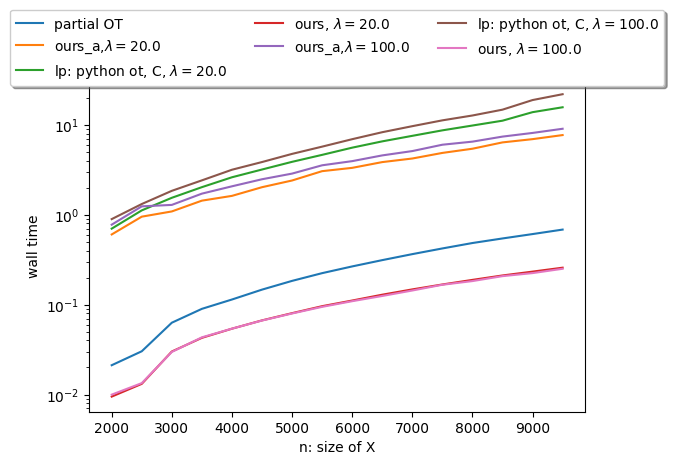

In [38]:
#test1
Lambda_list=np.array([20.0,100.0]).astype(np.float32)
time_pot_list=[]
time_v2_list=[[],[]]
time_v2_a_list=[[],[]]
time_lp_list=[[],[]]
time_new_list=[[],[]]
time_sinkhorn_list=[[],[]]
#time5_list=[]

start_n=1500
end_n=10000
device='cpu'
step=500
k=10
print('start')

for n in range (start_n,end_n,step):
    m=n+1000
    print('n',n)
    print('m',m)
    time_pot=0
    time_v2=np.zeros(2)
    time_v2_a=np.zeros(2)
    time_lp=np.zeros(2)
    time_new=np.zeros(2)
    time_sinkhorn=np.zeros(2)
    mu=np.ones(n,dtype=np.float32)
    nu=np.ones(m,dtype=np.float32)

    for i in range (k):
        X=np.random.uniform(-20,20,n).astype(np.float32)
        Y=np.random.uniform(-40,40,m).astype(np.float32)
        X1=X.copy()
        Y1=Y.copy()
        start_time = time.time()
        X1.sort()
        Y1.sort()        
        cost1,L1=pot_32(X1,Y1)
        end_time = time.time()
        time_pot+=end_time-start_time

        for j in range(len(Lambda_list)):
            Lambda=Lambda_list[j]
            
            
#            start_time = time.time()

#             X1.sort()
#             Y1.sort()       
#             opt_1d_v2(X1,Y1,Lambda)
#             end_time = time.time()
#             time_v2[j]+=end_time-start_time
            
#             X1=X.copy()
#             Y1=Y.copy()
#             start_time = time.time()
# #            M=cost_matrix(X1,Y1)
#             X1.sort()
#             Y1.sort()
#             opt_1d_v2_a(X1,Y1,Lambda)
    
             
            X1=X.copy()
            Y1=Y.copy()
            start_time = time.time()
            X1.sort()
            Y1.sort()       
            M=cost_matrix(X1,Y1)
            obj,phi,psi,piRow,piCol=solve_opt_32(M,Lambda) #,verbose=False,plots=False)
            #L_new=getPiFromRow(n,m,piRow)
            end_time = time.time()
            time_new[j]+=end_time-start_time
    
            
    #        Y1=Y[0:n]
            numItermax=int(200000*n/1000)
            X1=X.copy()
            Y1=Y.copy()
            start_time = time.time()
            cost,gamma=opt_lp(X1,Y1,Lambda,numItermax)
            end_time = time.time()
            time_lp[j]+=end_time-start_time
            

            X1=X.copy()
            Y1=Y.copy()
            reg=np.float32(max(Lambda/40,0.1))
            start_time=time.time()
            M=cost_matrix(X1,Y1)
            sinkhorn_knopp_opt_32(mu,nu,M,Lambda,reg,numItermax=numItermax)
            end_time = time.time()
            time_sinkhorn[j]+=end_time-start_time
              
    
    
    time_pot_list.append(time_pot/k)
    for j in range(2):
        time_v2_list[j].append(time_v2[j]/k)
        time_v2_a_list[j].append(time_v2_a[j]/k)
        time_lp_list[j].append(time_lp[j]/k)
        time_new_list[j].append(time_new[j]/k)
        time_sinkhorn_list[j].append(time_sinkhorn[j]/k)
    print(time_sinkhorn_list[j][-1]) 

time_list={}
time_list['pot']=time_pot_list
time_list['v2']=time_v2_list
time_list['v2_a']=time_v2_a_list
time_list['lp']=time_lp_list 
time_list['new']=time_new_list
time_list['sinkhorn']=time_sinkhorn_list

torch.save(time_list,'experiment/test/results/time_list_numba.pt')

time_list=torch.load('experiment/test/results/time_list_numba.pt')
time_pot_list=time_list['pot']
time_v2_list=time_list['v2']
time_v2_a_list=time_list['v2_a']
time_lp_list=time_list['lp']
time_new_list=time_list['new']
time_sinkhorn_list=time_list['sinkhorn']

start_n=1500
end_n=10000
device='cpu'
step=500
k=10
n_list=range(start_n,end_n,step)[1:]
fig = plt.figure()
ax = plt.subplot(111)

plt.semilogy(n_list,time_pot_list[1:],label='partial OT')
for j in range(2):
#    plt.semilogy(n_list,time_v2_list[j][1:],label='ours,$\lambda=$'+str(Lambda_list[j]))
    plt.semilogy(n_list,time_sinkhorn_list[j][1:],label='ours_a,$\lambda=$'+str(Lambda_list[j]))
    plt.semilogy(n_list,time_lp_list[j][1:],label='lp: python ot, C, $\lambda=$'+str(Lambda_list[j]))
    plt.semilogy(n_list,time_new_list[j][1:],label='ours, $\lambda=$'+str(Lambda_list[j]))
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.23),
          fancybox=True, shadow=True, ncol=3)
plt.xlabel('n: size of X')
plt.ylabel("wall time")
plt.savefig('experiment/test/results/time_numba.png',format='png',dpi=800,bbox_inches='tight')
#plt.title('wall-clock time with accelaration')
plt.show()

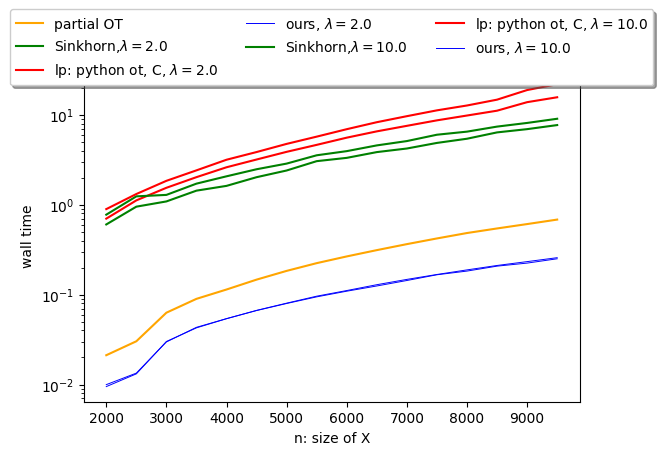

In [34]:
start_n=1500
end_n=10000
device='cpu'
step=500
k=10
n_list=range(start_n,end_n,step)[1:]
fig = plt.figure()
ax = plt.subplot(111)
time_list=torch.load('experiment/test/results/time_list_numba.pt')
time_pot_list=time_list['pot']
time_v2_list=time_list['v2']
time_v2_a_list=time_list['v2_a']
time_lp_list=time_list['lp']
time_new_list=time_list['new']
time_sinkhorn_list=time_list['sinkhorn']


plt.semilogy(n_list,time_pot_list[1:],'orange',label='partial OT')
for j in range(2):
#    plt.semilogy(n_list,time_v2_list[j][1:],label='ours,$\lambda=$'+str(Lambda_list[j]))
    plt.semilogy(n_list,time_sinkhorn_list[j][1:],'green',label='Sinkhorn,$\lambda=$'+str(Lambda_list[j]))
    plt.semilogy(n_list,time_lp_list[j][1:],'red',label='lp: python ot, C, $\lambda=$'+str(Lambda_list[j]))
    plt.semilogy(n_list,time_new_list[j][1:],'blue',linewidth=0.7,label='ours, $\lambda=$'+str(Lambda_list[j]))
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.20),
          fancybox=True, shadow=True, ncol=3)
plt.xlabel('n: size of X')
plt.ylabel("wall time")
plt.savefig('experiment/test/results/time_uniform_32.png',format='png',dpi=800,bbox_inches='tight')
#plt.title('wall-clock time with accelaration')
plt.show()

In [16]:
@nb.njit(['(float64[:])(float64[:],float64[:],int64)'],fastmath=True)
def Gaussian_mixture(mu_list, variance_list,n):
    N=mu_list.shape[0]
    indices=np.random.randint(0,N,n)
    X=np.zeros(n)
    for i in range(n):
        X[i]=np.random.normal(mu_list[indices[i]],variance_list[indices[i]])
    return X

# @nb.njit(['(float32[:])(float32[:],float32[:],int64)'],fastmath=True)
# def Gaussian_mixture_32(mu_list, variance_list,n):
#     N=mu_list.shape[0]
#     indices=np.random.randint(0,N,n)
#     X=np.zeros(n,dtype=np.float32)
#     for i in range(n):
#         X[i]=np.float32(np.random.normal(mu_list[indices[i]],variance_list[indices[i]]))
#     return X


    
    

In [17]:
mu1=np.linspace(-4,4,5)
mu2=np.linspace(-5,5,6)
var1=np.ones(5)
var2=np.ones(6)
X=Gaussian_mixture(mu1,var1,10)
print(X)

[ 5.43949762 -0.95486728  1.48640772 -0.21362046 -0.00693473 -1.63088248
  2.24904571  6.23082783 -1.03992554  0.27571546]


start
n 1500
m 2500
<class 'numpy.float32'>
0.09961049556732178
n 2000
m 3000
<class 'numpy.float32'>
0.18713085651397704
n 2500
m 3500
<class 'numpy.float32'>
0.3486999750137329
n 3000
m 4000
<class 'numpy.float32'>
0.5792428255081177
n 3500
m 4500
<class 'numpy.float32'>
0.9303261280059815
n 4000
m 5000
<class 'numpy.float32'>
1.9088943958282472
n 4500
m 5500
<class 'numpy.float32'>
3.769697976112366
n 5000
m 6000
<class 'numpy.float32'>
10.101075983047485
n 5500
m 6500
<class 'numpy.float32'>
14.35975148677826
n 6000
m 7000
<class 'numpy.float32'>
20.929134917259216
n 6500
m 7500
<class 'numpy.float32'>
28.872381186485292
n 7000
m 8000
<class 'numpy.float32'>
33.99246287345886
n 7500
m 8500
<class 'numpy.float32'>
31.113644123077393
n 8000
m 9000
<class 'numpy.float32'>
35.172746539115906
n 8500
m 9500
<class 'numpy.float32'>
35.926887679100034
n 9000
m 10000
<class 'numpy.float32'>
30.91623110771179
n 9500
m 10500
<class 'numpy.float32'>
30.274378991127016


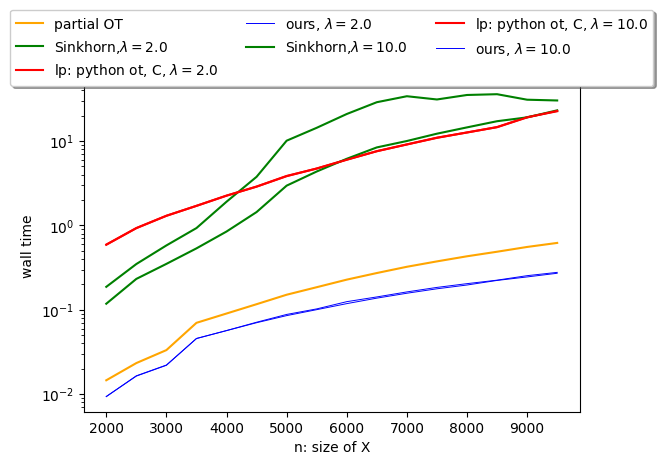

In [39]:
#test2
mean1=np.linspace(-4,4,5)
mean2=np.linspace(-5,5,6)
var1=np.ones(5)
var2=np.ones(6)
#Lambda=60
Lambda_list=np.array([2.0,10.0]).astype(np.float32)
time_pot_list=[]
time_v2_list=[[],[]]
time_v2_a_list=[[],[]]
time_lp_list=[[],[]]
time_new_list=[[],[]]
time_sinkhorn_list=[[],[]]
#time5_list=[]

start_n=1500
end_n=10000
device='cpu'
step=500
k=5
print('start')

for n in range (start_n,end_n,step):
    m=n+1000
    print('n',n)
    print('m',m)
    time_pot=0
    time_v2=np.zeros(2)
    time_v2_a=np.zeros(2)
    time_lp=np.zeros(2)
    time_new=np.zeros(2)
    time_sinkhorn=np.zeros(2)
    mu=np.ones(n,dtype=np.float32)
    nu=np.ones(m,dtype=np.float32)

    for i in range (k):
        X=Gaussian_mixture(mean1,var1,n).astype(np.float32) #np.random.uniform(-20,20,n).astype(np.float32)
        Y=Gaussian_mixture(mean2,var2,m).astype(np.float32) #np.random.uniform(-40,40,m).astype(np.float32)
        X1=X.copy()
        Y1=Y.copy()
        start_time = time.time()
        X1.sort()
        Y1.sort()        
        cost1,L1=pot_32(X1,Y1)
        end_time = time.time()
        time_pot+=end_time-start_time

        for j in range(len(Lambda_list)):
            Lambda=Lambda_list[j]
            
            
#            start_time = time.time()

#             X1.sort()
#             Y1.sort()       
#             opt_1d_v2(X1,Y1,Lambda)
#             end_time = time.time()
#             time_v2[j]+=end_time-start_time
            
#             X1=X.copy()
#             Y1=Y.copy()
#             start_time = time.time()
# #            M=cost_matrix(X1,Y1)
#             X1.sort()
#             Y1.sort()
#             opt_1d_v2_a(X1,Y1,Lambda)
    
             
            X1=X.copy()
            Y1=Y.copy()
            start_time = time.time()
            X1.sort()
            Y1.sort()       
            M=cost_matrix(X1,Y1)
            obj,phi,psi,piRow,piCol=solve_opt_32(M,Lambda) #,verbose=False,plots=False)
            #L_new=getPiFromRow(n,m,piRow)
            end_time = time.time()
            time_new[j]+=end_time-start_time
    
            
    #        Y1=Y[0:n]
            numItermax=int(200000*n/1000)
            X1=X.copy()
            Y1=Y.copy()
            start_time = time.time()
            cost,gamma=opt_lp(X1,Y1,Lambda,numItermax)
            end_time = time.time()
            time_lp[j]+=end_time-start_time
            

            X1=X.copy()
            Y1=Y.copy()
            numItermax=int(100*n)
#            print(mu.dtype)
            reg=np.float32(max(Lambda/10,0.1))
            start_time=time.time()
            M=cost_matrix(X1,Y1)
            sinkhorn_knopp_opt_32(mu,nu,M,Lambda,reg,numItermax=numItermax)
            end_time = time.time()
            time_sinkhorn[j]+=end_time-start_time
              
    
    
    time_pot_list.append(time_pot/k)
    for j in range(2):
        time_v2_list[j].append(time_v2[j]/k)
        time_v2_a_list[j].append(time_v2_a[j]/k)
        time_lp_list[j].append(time_lp[j]/k)
        time_new_list[j].append(time_new[j]/k)
        time_sinkhorn_list[j].append(time_sinkhorn[j]/k)
    #print(type(reg))
    print(time_sinkhorn_list[0][-1]) 

time_list={}
time_list['pot']=time_pot_list
time_list['v2']=time_v2_list
time_list['v2_a']=time_v2_a_list
time_list['lp']=time_lp_list 
time_list['new']=time_new_list
time_list['sinkhorn']=time_sinkhorn_list

torch.save(time_list,'experiment/test/results/time_list_numba_gaussian.pt')

time_list=torch.load('experiment/test/results/time_list_numba_gaussian.pt')
time_pot_list=time_list['pot']
time_v2_list=time_list['v2']
time_v2_a_list=time_list['v2_a']
time_lp_list=time_list['lp']
time_new_list=time_list['new']
time_sinkhorn_list=time_list['sinkhorn']

start_n=1500
end_n=10000
device='cpu'
step=500
k=10
n_list=range(start_n,end_n,step)[1:]
fig = plt.figure()
ax = plt.subplot(111)

plt.semilogy(n_list,time_pot_list[1:],'orange',label='partial OT')
for j in range(2):
#    plt.semilogy(n_list,time_v2_list[j][1:],label='ours,$\lambda=$'+str(Lambda_list[j]))
    plt.semilogy(n_list,time_sinkhorn_list[j][1:],'green',label='Sinkhorn,$\lambda=$'+str(Lambda_list[j]))
    plt.semilogy(n_list,time_lp_list[j][1:],'red',label='lp: python ot, C, $\lambda=$'+str(Lambda_list[j]))
    plt.semilogy(n_list,time_new_list[j][1:],'blue',linewidth=0.7,label='ours, $\lambda=$'+str(Lambda_list[j]))
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.23),
          fancybox=True, shadow=True, ncol=3)
plt.xlabel('n: size of X')
plt.ylabel("wall time")
plt.savefig('experiment/test/results/time_numba.png',format='png',dpi=800,bbox_inches='tight')
#plt.title('wall-clock time with accelaration')
plt.show()

In [37]:
time_sinkhorn_list

[[0.1151350975036621,
  0.21945080757141114,
  0.4094530582427979,
  1.0383500576019287,
  1.9707772731781006,
  3.0151814460754394,
  5.923446941375732,
  14.621810913085938,
  27.42362961769104,
  37.30857934951782,
  29.938614892959595,
  27.163487720489503,
  19.23037395477295,
  17.647161769866944,
  22.659733724594116,
  22.345075798034667,
  21.921456384658814],
 [0.08024487495422364,
  0.15455927848815917,
  0.27326092720031736,
  0.4823433876037598,
  0.8247636318206787,
  1.1099267482757569,
  2.0573440551757813,
  4.082003402709961,
  7.284257459640503,
  9.868714141845704,
  12.999133491516114,
  16.27747497558594,
  19.23168902397156,
  22.64235725402832,
  26.595413494110108,
  29.34384951591492,
  35.1268087387085]]

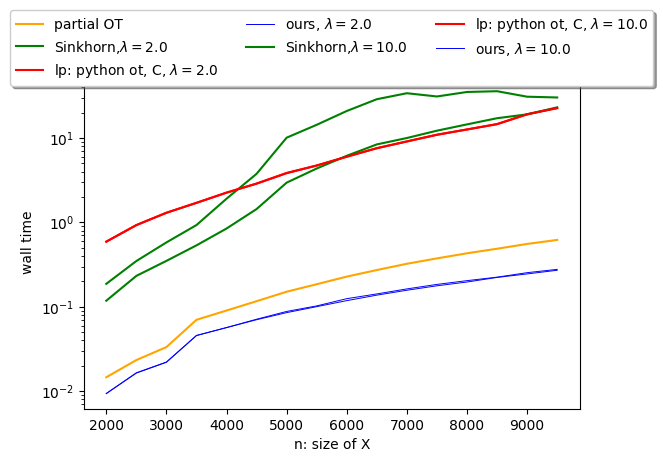

In [43]:
time_list=torch.load('experiment/test/results/time_list_numba_gaussian.pt')
time_pot_list=time_list['pot']
time_v2_list=time_list['v2']
time_v2_a_list=time_list['v2_a']
time_lp_list=time_list['lp']
time_new_list=time_list['new']
time_sinkhorn_list=time_list['sinkhorn']

start_n=1500
end_n=10000
device='cpu'
step=500
k=10
n_list=range(start_n,end_n,step)[1:]
fig = plt.figure()
ax = plt.subplot(111)

plt.semilogy(n_list,time_pot_list[1:],'orange',label='partial OT')
for j in range(2):
#    plt.semilogy(n_list,time_v2_list[j][1:],label='ours,$\lambda=$'+str(Lambda_list[j]))
    plt.semilogy(n_list,time_sinkhorn_list[j][1:],'green',label='Sinkhorn,$\lambda=$'+str(Lambda_list[j]))
    plt.semilogy(n_list,time_lp_list[j][1:],'red',label='lp: python ot, C, $\lambda=$'+str(Lambda_list[j]))
    plt.semilogy(n_list,time_new_list[j][1:],'blue',linewidth=0.7,label='ours, $\lambda=$'+str(Lambda_list[j]))
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.22),
          fancybox=True, shadow=True, ncol=3)
plt.xlabel('n: size of X')
plt.ylabel("wall time")
plt.savefig('experiment/test/results/time_gaussian_32.png',format='png',dpi=800,bbox_inches='tight')
#plt.title('wall-clock time with accelaration')
plt.show()

In [21]:
reg=max(Lambda/40,0.1)
start_time=time.time()
M=cost_matrix(X1,Y1)

print(mu.dtype)
print(nu.dtype)
print(M.dtype)
print(type(Lambda))
reg=np.float32(max(Lambda/40,0.1))

print(type(reg))
#sinkhorn_knopp_opt_32(mu,nu,M,Lambda,reg,numItermax=numItermax)
end_time = time.time()



float32
float32
float32
<class 'numpy.float32'>
0.1
<class 'numpy.float32'>


In [34]:
mu = np.array([.1, .2])
nu =np.array([.1, .1])
M = np.array([[0., 1.], [2., 3.]])
mass=0.1
reg=1.0
K=entropic_opt(mu,nu,M,mass,reg,1000000)
print(K)

[[0.06439143 0.02368828]
 [0.00871443 0.00320586]]


In [35]:
start=time.time()
for k in range(10):
#    A=np.random.rand(5000,3)
    B=np.random.rand(10000,3)
end=time.time()
print(end-start)
print('hello')

0.003829479217529297
hello


In [ ]:
start=time.time()
for k in range(10):
    A=np.random.rand(5000,3)
    B=np.random.rand(10000,3)
    cost_matrix_d(A,B)
end=time.time()
print(end-start)

In [64]:
@nb.njit(['float32[:,:](float32[:,:],float32[:,:])'],fastmath=True)
def cost_matrix_d_321(X,Y):
    '''
    input: 
        X: (n,) float np array
        Y: (m,) float np array
    output:
        M: n*m matrix, M_ij=c(X_i,Y_j) where c is defined by cost_function.
    
    '''
    n,d=X.shape
    m=Y.shape[0]
    M=np.empty((n,m),dtype=np.float32) 
    for i in range(n):
        M[i]=np.sum(cost_function(X[i],Y),1)
    return M

In [65]:

start=time.time()
for i in range(10):
    X=np.random.rand(10000,3).astype(np.float32)
    Y=np.random.rand(12000,3).astype(np.float32)
    M1=cost_matrix_d_321(X,Y)
end=time.time()
print(end-start)

7.603938817977905


In [66]:
start=time.time()
for i in range(10):
    X=np.random.rand(10000,3).astype(np.float32)
    Y=np.random.rand(12000,3).astype(np.float32)
    M1=cost_matrix_d_32(X,Y)
end=time.time()
print(end-start)

11.36817717552185
